In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_len = 900
embed_dim = 100

In [3]:
LABEL_LIST = [
    "O",
    "B-EDU", "I-EDU",
    "B-HSK", "I-HSK",
    "B-YOE", "I-YOE",
    "B-ORG", "I-ORG",
    "B-JOB", "I-JOB",
    "B-LOC", "I-LOC",
]
label2id = {label: idx for idx, label in enumerate(LABEL_LIST)}
id2label = {idx: label for label, idx in label2id.items()}
NUM_CLASSES = len(label2id)


In [4]:
df = pd.read_csv("Final Processed Dataset.csv")
df["parsed_list"] = df["parsed_list"].apply(ast.literal_eval)

In [5]:
# Create list of (word, tag) pairs per sentence
data = [
    [(token[0], token[1]) for token in row if isinstance(token, (list, tuple)) and len(token) >= 2]
    for row in df['parsed_list']
]

# Now separate words and tags
X = [[word for word, tag in sentence] for sentence in data]
y = [[tag for word, tag in sentence] for sentence in data]


In [6]:
# Word vocabulary
words = list(set(token for sentence in X for token in sentence))
word2idx = {word: idx + 2 for idx, word in enumerate(words)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1
idx2word = {idx: word for word, idx in word2idx.items()}

# Label vocabulary
valid_tags = {
    "B-HSK", "I-HSK", "B-JOB", "I-JOB", "B-YOE", "I-YOE",
    "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-EDU", "I-EDU", "O"
}
y = [[tag if tag in valid_tags else "O" for tag in seq] for seq in y]

from sklearn.preprocessing import LabelEncoder

tag_encoder = LabelEncoder()
flat_tags = [tag for seq in y for tag in seq]
tag_encoder.fit(flat_tags)

tag2idx = {tag: idx for idx, tag in enumerate(tag_encoder.classes_)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}


In [7]:
from sklearn.model_selection import train_test_split

# Split into temp/test first
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then split temp into train/val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42)


In [8]:


max_len = 900

def encode_and_pad(seq_list, mapping, pad_value):
    """Encode sequences and pad them to max_len using PyTorch."""
    encoded = [
        torch.tensor([mapping.get(item, mapping.get("UNK")) for item in seq], dtype=torch.long)
        for seq in seq_list
    ]
    # Manually pad to max_len
    padded = [
        torch.cat([seq, torch.full((max_len - len(seq),), pad_value)]) if len(seq) < max_len else seq[:max_len]
        for seq in encoded
    ]
    return torch.stack(padded)

# Word sequences
X_train_pad = encode_and_pad(X_train, word2idx, pad_value=word2idx["PAD"])
X_val_pad   = encode_and_pad(X_val, word2idx, pad_value=word2idx["PAD"])
X_test_pad  = encode_and_pad(X_test, word2idx, pad_value=word2idx["PAD"])

# Label sequences
y_train_pad = encode_and_pad(y_train, tag2idx, pad_value=tag2idx["O"])
y_val_pad   = encode_and_pad(y_val, tag2idx, pad_value=tag2idx["O"])
y_test_pad  = encode_and_pad(y_test, tag2idx, pad_value=tag2idx["O"])


In [9]:
print("X_train shape:", X_train_pad.shape)
print("y_train shape:", y_train_pad.shape)
print("Vocab size:", len(word2idx))
print("Tag set size:", len(tag2idx))


X_train shape: torch.Size([1392, 900])
y_train shape: torch.Size([1392, 900])
Vocab size: 16028
Tag set size: 13


In [10]:
def load_glove(path, word2idx, dim=100):
    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vec = np.array(parts[1:], dtype='float32')
            embeddings_index[word] = vec

    matrix = np.zeros((len(word2idx), dim))
    for word, idx in word2idx.items():
        matrix[idx] = embeddings_index.get(word, np.random.normal(scale=0.6, size=(dim,)))
    return torch.tensor(matrix, dtype=torch.float32)

embedding_matrix = load_glove("glove.6B.100d.txt", word2idx, embed_dim)

In [11]:
all_train_labels = [label for sequence in y_train for label in sequence]
label_counts = Counter(all_train_labels)
total_count = sum(label_counts.values())
class_weights = {tag2idx[tag]: total_count / count for tag, count in label_counts.items()}
max_weight = max(class_weights.values())
normalized_weights = {k: v / max_weight for k, v in class_weights.items()}
weights_tensor = torch.ones(len(tag2idx))
for idx, weight in normalized_weights.items():
    weights_tensor[idx] = weight


In [12]:
class NERDataset(Dataset): 
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(NERDataset(X_train_pad, y_train_pad), batch_size=16, shuffle=True)
val_loader   = DataLoader(NERDataset(X_val_pad, y_val_pad), batch_size=16)
test_loader  = DataLoader(NERDataset(X_test_pad, y_test_pad), batch_size=16)

In [13]:

class CNN_NER(nn.Module): #Create CNN Class#
    def __init__(self, vocab_size, embed_dim, num_classes, embedding_matrix):
        super(CNN_NER, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x = self.dropout(x)
        return self.classifier(x)

model = CNN_NER(len(word2idx), embed_dim, len(tag2idx), embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device), ignore_index=tag2idx["O"])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [14]:
def extract_entities(label_seq):
    """Extract entity spans (start, end, type) from a label sequence."""
    entities = set()
    start, entity_type = None, None
    for i, label in enumerate(label_seq):
        if label.startswith("B-"):
            if start is not None:
                entities.add((start, i - 1, entity_type))
            start = i
            entity_type = label[2:]
        elif label.startswith("I-") and entity_type == label[2:]:
            continue
        else:
            if start is not None:
                entities.add((start, i - 1, entity_type))
                start, entity_type = None, None
    if start is not None:
        entities.add((start, len(label_seq) - 1, entity_type))
    return entities


In [15]:
from seqeval.metrics import classification_report, f1_score

best_val_f1 = 0
best_report = ""
patience = 3
patience_counter = 0

for epoch in range(20):
    model.train()
    total_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/20"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits.view(-1, logits.shape[-1]), y_batch.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"\nEpoch {epoch+1}: Training Loss = {total_loss:.4f}")

    # === Validation ===
    model.eval()
    val_loss = 0
    all_preds, all_trues = [], []

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)
            val_logits = model(X_val_batch)
            loss = criterion(val_logits.view(-1, logits.shape[-1]), y_val_batch.view(-1))
            val_loss += loss.item()

            pred_labels = torch.argmax(val_logits, dim=-1).cpu().tolist()
            true_labels = y_val_batch.cpu().tolist()

            for preds, trues in zip(pred_labels, true_labels):
                length = sum([1 for t in trues if t != tag2idx["O"]])
                pred_tags = [idx2tag[p] for p in preds[:length]]
                true_tags = [idx2tag[t] for t in trues[:length]]
                all_preds.append(pred_tags)
                all_trues.append(true_tags)

    val_loss /= len(val_loader)
    val_f1 = f1_score(all_trues, all_preds)

    print(f"Epoch {epoch+1}: Validation Loss = {val_loss:.4f}")
    print(f"Epoch {epoch+1}: Validation F1   = {val_f1:.4f}")

    # === Early Stopping Check ===
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        best_report = classification_report(all_trues, all_preds, digits=4)
        print("Validation F1 improved.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# === Final Report ===
print("\n📋 Best ConLL-style Classification Report:")
print(best_report)


Epoch 1/20: 100%|██████████| 87/87 [00:02<00:00, 35.64it/s]



Epoch 1: Training Loss = 122.7909
Epoch 1: Validation Loss = 0.8522
Epoch 1: Validation F1   = 0.0611
Validation F1 improved.


Epoch 2/20: 100%|██████████| 87/87 [00:02<00:00, 37.41it/s]



Epoch 2: Training Loss = 71.4844
Epoch 2: Validation Loss = 0.7274
Epoch 2: Validation F1   = 0.0551
No improvement. Patience: 1/3


Epoch 3/20: 100%|██████████| 87/87 [00:02<00:00, 36.04it/s]



Epoch 3: Training Loss = 63.6315
Epoch 3: Validation Loss = 0.6802
Epoch 3: Validation F1   = 0.0505
No improvement. Patience: 2/3


Epoch 4/20: 100%|██████████| 87/87 [00:02<00:00, 37.03it/s]



Epoch 4: Training Loss = 59.4414
Epoch 4: Validation Loss = 0.6574
Epoch 4: Validation F1   = 0.0493
No improvement. Patience: 3/3
Early stopping triggered.

📋 Best ConLL-style Classification Report:
              precision    recall  f1-score   support

         EDU     0.0022    0.1333    0.0043        15
         HSK     0.0832    0.2467    0.1244      1054
         JOB     0.0358    0.2834    0.0635       247
         LOC     0.0141    0.1130    0.0250       301
         ORG     0.0138    0.1622    0.0254       296
         YOE     0.0516    0.4107    0.0916        56

   micro avg     0.0354    0.2219    0.0611      1969
   macro avg     0.0334    0.2249    0.0557      1969
weighted avg     0.0547    0.2219    0.0849      1969



In [16]:

print("\nFinal Evaluation on Test Set")

model.eval()
all_preds_test, all_trues_test = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        logits = model(X_batch)
        pred_labels = torch.argmax(logits, dim=-1).cpu().tolist()
        true_labels = y_batch.cpu().tolist()

        for preds, trues in zip(pred_labels, true_labels):
            length = sum([1 for t in trues if t != tag2idx["O"]])
            pred_tags = [idx2tag[p] for p in preds[:length]]
            true_tags = [idx2tag[t] for t in trues[:length]]
            all_preds_test.append(pred_tags)
            all_trues_test.append(true_tags)

# === SemEval-Style Evaluation ===
print("\n🧾 SemEval Evaluation on Test Set:")
print(classification_report(all_trues_test, all_preds_test, digits=4))

f1 = f1_score(all_trues_test, all_preds_test)
print(f"🏆 Overall Entity-Level F1 Score: {f1:.4f}")



Final Evaluation on Test Set

🧾 SemEval Evaluation on Test Set:
              precision    recall  f1-score   support

         EDU     0.0007    0.0625    0.0013        16
         HSK     0.0494    0.2028    0.0794      1598
         JOB     0.0229    0.2009    0.0412       448
         LOC     0.0381    0.2117    0.0646       444
         ORG     0.0196    0.2461    0.0364       512
         YOE     0.0222    0.2824    0.0412        85

   micro avg     0.0300    0.2124    0.0526      3103
   macro avg     0.0255    0.2011    0.0440      3103
weighted avg     0.0381    0.2124    0.0632      3103

🏆 Overall Entity-Level F1 Score: 0.0526


In [34]:
pip install ner-eval

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement ner-eval (from versions: none)
ERROR: No matching distribution found for ner-eval


In [ ]:

def bio_to_spans(tags):
    spans = []
    start = None
    label = None
    for i, tag in enumerate(tags):
        if tag.startswith("B-"):
            if start is not None:
                spans.append((start, i-1, label))
            start = i
            label = tag[2:]
        elif tag.startswith("I-") and label == tag[2:]:
            continue
        else:
            if start is not None:
                spans.append((start, i-1, label))
                start = None
                label = None
    if start is not None:
        spans.append((start, len(tags)-1, label))
    return spans


In [24]:
true_types = []
pred_types = []

for gold_seq, pred_seq in zip(all_trues_test, all_preds_test):
    gold_spans = bio_to_spans(gold_seq)
    pred_spans = bio_to_spans(pred_seq)
    matched_gold = set()

    for pred_span in pred_spans:
        if pred_span in gold_spans:
            true_types.append(pred_span[2])
            pred_types.append(pred_span[2])
            matched_gold.add(pred_span)
        else:
            found = False
            for gold_span in gold_spans:
                if gold_span[2] == pred_span[2] and max(gold_span[0], pred_span[0]) <= min(gold_span[1], pred_span[1]):
                    true_types.append(gold_span[2])
                    pred_types.append(pred_span[2])
                    matched_gold.add(gold_span)
                    found = True
                    break
            if not found:
                true_types.append("O")
                pred_types.append(pred_span[2])

    for gold_span in gold_spans:
        if gold_span not in matched_gold:
            true_types.append(gold_span[2])
            pred_types.append("O")


In [32]:
def show_good_and_bad_examples(pred_seqs, true_seqs, token_seqs, num_tokens_context=2):
    """
    Show one good and one bad prediction with context around entity span.
    Good = all spans correct.
    Bad = missed at least one gold span entirely.
    """
    good_found = False
    bad_found = False

    for tokens, preds, trues in zip(token_seqs, pred_seqs, true_seqs):
        pred_spans = set(bio_to_spans(preds))
        true_spans = set(bio_to_spans(trues))

        # ✅ GOOD example: all spans are correct and none missing or spurious
        if pred_spans == true_spans and not good_found:
            for span in sorted(true_spans):
                start, end, label = span
                center = start
                context_start = max(center - num_tokens_context, 0)
                context_end = min(center + num_tokens_context + 1, len(tokens))

                print("\n🟢 GOOD EXAMPLE (All Entities Correct in Context):")
                print("Context:           ", " ".join(tokens[context_start:context_end]))
                print("Predicted Labels:  ", preds[context_start:context_end])
                print("True Labels:       ", trues[context_start:context_end])
                good_found = True
                break  # show only one

        # ❌ BAD example: at least one gold span is completely missed
        missed = true_spans - pred_spans
        if missed and not bad_found:
            for span in sorted(missed):
                start, end, label = span
                center = start
                context_start = max(center - num_tokens_context, 0)
                context_end = min(center + num_tokens_context + 1, len(tokens))

                print("\n🔴 BAD EXAMPLE (Missed Entity):")
                print("Context:           ", " ".join(tokens[context_start:context_end]))
                print("Predicted Labels:  ", preds[context_start:context_end])
                print("True Labels:       ", trues[context_start:context_end])
                bad_found = True
                break

        if good_found and bad_found:
            break


In [33]:
all_tokens_test = []
for i in range(X_test_pad.size(0)):
    token_ids = X_test_pad[i].tolist()
    length = len(all_trues_test[i])
    tokens = [idx2word.get(idx, "UNK") for idx in token_ids[:length]]
    all_tokens_test.append(tokens)

show_good_and_bad_examples(all_preds_test, all_trues_test, all_tokens_test,2)


🔴 BAD EXAMPLE (Missed Entity):
Context:            world class voice - forward
Predicted Labels:   ['I-ORG', 'I-ORG', 'B-HSK', 'I-HSK', 'I-JOB']
True Labels:        ['O', 'O', 'B-HSK', 'I-HSK', 'I-HSK']


<Figure size 1000x800 with 0 Axes>

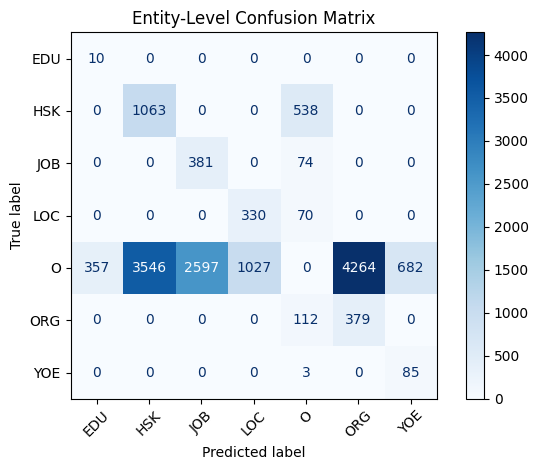

In [21]:
labels = sorted(set(true_types + pred_types))

cm = confusion_matrix(true_types, pred_types, labels=labels)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Entity-Level Confusion Matrix")
plt.tight_layout()
plt.show()


In [22]:
# Save the entire model (architecture + weights)
torch.save(model.state_dict(), "cnn_ner_model.pt")


In [23]:
# Save word2idx and tag2idx using pickle
with open("ner_vocab.pkl", "wb") as f:
    pickle.dump({
        "word2idx": word2idx,
        "tag2idx": tag2idx,
        "idx2tag": idx2tag
    }, f)

# Save embedding matrix separately using torch
torch.save(embedding_matrix, "embedding_matrix.pt")
